**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources, such as [pymc](https://github.com/pymc-devs/pymc-examples/blob/main/examples/gaussian_processes/log-gaussian-cox-process.ipynb). Every effort has been made to trace copyright holders of the materials used in this notebook. The author apologizes for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Log Gaussian Cox spatial processes

## El Proceso de Poisson

El proceso de puntos de Poisson, o proceso de Poisson, o campo de puntos de Poisson, es un tipo de objeto aleatorio que consiste en puntos posicionados aleatoriamente ubicados en algún espacio matemático subyacente (Keeler 2016).

El proceso de puntos de Poisson está relacionado con la distribución de Poisson, que implica que la probabilidad de que una variable aleatoria de Poisson $N$ sea igual a $n$ es:

$ 
P\{N = n\} = \frac{\lambda^n e^{-\lambda}}{n!} 
$

donde $n!$ denota el factorial de $n$ y $\lambda$ es el parámetro único de Poisson que se usa para definir la distribución de Poisson.

El proceso de puntos de Poisson a veces se llama proceso puramente o completamente aleatorio. Este proceso tiene la propiedad de que el número de eventos $N(A)$ en una región acotada $A \in \mathbb{R}^d$ está distribuido de manera independiente y uniforme sobre $A$. Esto significa que la ubicación de un punto no afecta las probabilidades de que otros puntos aparezcan cerca y que no hay regiones donde los eventos sean más propensos a aparecer.

### Procesos de Puntos de Poisson Homogéneos e Inhomogéneos

Si un proceso de puntos de Poisson tiene un parámetro constante, digamos, $\lambda$, entonces se llama proceso de Poisson homogéneo (o estacionario) (HPP). El parámetro $\lambda$, llamado intensidad, está relacionado con el número esperado (o promedio) de puntos de Poisson que existen en alguna región acotada. El parámetro $\lambda$ se puede interpretar como el número promedio de puntos por alguna unidad de longitud, área o volumen, dependiendo del espacio matemático subyacente, por lo que a veces se llama densidad media (Keeler 2016).

El HPP es estacionario y los patrones y procesos de puntos espaciales son isotrópicos. Es estacionario porque la intensidad es constante y, además, es isotrópico porque la intensidad es invariante a la rotación de $\mathbb{R}^d$ (Baddeley 2007).

Una generalización del HPP que permite una intensidad no constante $\lambda$ se llama proceso de Poisson inhomogéneo (IPP). Tanto el HPP como el IPP asumen que los eventos ocurren de manera independiente y están distribuidos según una intensidad dada, $\lambda$. La principal diferencia es que el HPP asume que la función de intensidad es constante ($\lambda = \text{const.}$), mientras que la intensidad de un IPP varía espacialmente ($\lambda = Z(u)$).

## El Proceso de Poisson Espacial

En el plano $(\mathbb{R}^2)$, el proceso de puntos de Poisson se conoce como proceso de Poisson espacial. En una región acotada $A$ en un plano $(\mathbb{R}^2)$, con $N(A)$ siendo el número (aleatorio) de puntos $N$ que existen en la región $A \subset \mathbb{R}^2$, un proceso de Poisson homogéneo con parámetro $\lambda > 0$ describe la probabilidad de que existan $n$ puntos en $A$ mediante:

$ 
P\{N(A) = n\} = \frac{\lambda^{|A|} (|A|)^n}{n!} e^{-\lambda |A|} 
$

donde $|A|$ denota el área de $A$ (Keeler 2016).


--

## Procesos Log-Gaussian Cox

Un patron de puntos establece la ocurrencia de eventos en una región de interés. Los procesos tipo Cox se refieren a que la intensidad $\lambda(s)$ varía en el espacio. Dada un area $A$, la probabilidad de observar un cierto número de puntos en dicha área sigue una distribución de Poisson con intensidad (valor esperado):
$$
\lambda_A=\int{\lambda(s)ds}
$$
La parte gaussiana de LGCP viene de la modelación $log(\lambda(s))$ como un Gaussiano latente (condicionado a un conjunto de parámetros), en un marco típico de GLM or GAM.

El proceso de Cox log-Gaussiano (LGCP) es un modelo probabilístico de patrones de puntos que se observan típicamente en el espacio o el tiempo. Tiene dos componentes principales. Primero, un campo de *intensidad* subyacente $\lambda(s)$ de valores reales positivos se modela sobre todo el dominio $X$ utilizando un proceso Gaussiano transformado exponencialmente, lo que obliga a que $\lambda$ sea positivo. Luego, este campo de intensidad se utiliza para parametrizar un [proceso de puntos de Poisson](https://en.wikipedia.org/wiki/Poisson_point_process), que representa un mecanismo estocástico para colocar puntos en el espacio. Algunos fenómenos que pueden representarse con este modelo incluyen la incidencia de casos de cáncer en un condado o las ubicaciones espaciotemporales de eventos delictivos en una ciudad. Tanto las dimensiones espaciales como temporales se pueden manejar de manera equivalente dentro de este marco, aunque este tutorial solo aborda datos en dos dimensiones espaciales.

En términos más formales, si tenemos un espacio $X$ y $A\subseteq X$, la distribución sobre el número de puntos $Y_A$ que ocurren dentro del subconjunto $A$ se define como
$$Y_A \sim Poisson\left(\int_A \lambda(s) ds\right)$$
y el campo de intensidad se define como
$$\log \lambda(s) \sim GP(\mu(s), K(s,s'))$$
donde $GP(\mu(s), K(s,s'))$ denota un proceso Gaussiano con función de media $\mu(s)$ y núcleo de covarianza $K(s,s')$ para una ubicación $s \in X$. Este es uno de los modelos más simples de patrones de puntos de $n$ eventos registrados como ubicaciones $s_1,...,s_n$ en un espacio métrico arbitrario. En conjunto con un análisis Bayesiano, este modelo se puede utilizar para responder preguntas de interés como:
* ¿Implica un patrón de puntos observado un cambio estadísticamente significativo en las intensidades espaciales?
* ¿Cómo se verían los patrones muestreados aleatoriamente con las mismas propiedades estadísticas?
* ¿Existe una correlación estadística entre la *frecuencia* y la *magnitud* de los eventos puntuales?

En este cuaderno, utilizaremos una aproximación basada en una cuadrícula para el LGCP completo con PyMC para ajustar un modelo y analizar sus resúmenes posteriores. También exploraremos el uso de un proceso de Poisson marcado, una extensión de este modelo para tener en cuenta la distribución de *marcas* asociadas a cada punto de datos.

In [1]:
import warnings

from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import MatplotlibDeprecationWarning
from numpy.random import default_rng

warnings.filterwarnings(action="ignore", category=MatplotlibDeprecationWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Nuestros datos observacionales se refieren a 231 anémonas de mar cuyas dimensiones y ubicaciones en la costa francesa fueron registradas. Estos datos fueron tomados del paquete de modelado espacial *spatstat* en R, que está diseñado para abordar modelos como el LGCP y sus refinamientos posteriores. La fuente original de estos datos es el libro de texto *Spatial Data Analysis by Example* de Upton y Fingleton (1985), donde se puede encontrar una descripción más detallada de los datos.

In [2]:
data = pd.read_csv(pm.get_data("anemones.csv"))
n = data.shape[0]

In [3]:
data.head(3)

,x,y,marks
0,27,7,6
1,197,5,4
2,74,15,4


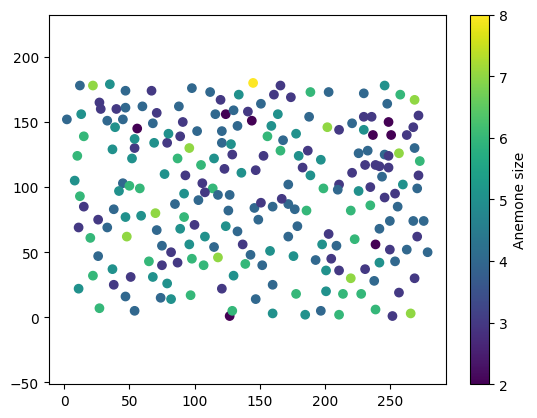

In [4]:
plt.scatter(data["x"], data["y"], c=data["marks"])
plt.colorbar(label="Anemone size")
plt.axis("equal");

La columna 'marks' indica el tamaño de cada anémona. Si fuéramos a modelar tanto las marcas como la distribución espacial de los puntos, estaríamos modelando un *proceso puntual de Poisson marcado*. Extender el modelo básico de patrones de puntos para incluir esta característica es la segunda parte de este cuaderno.
Aunque hay múltiples formas de realizar la inferencia, quizás la forma más simple es dividir nuestro dominio $X$ en muchas pequeñas piezas $A_1, A_2,...,A_M$ y fijar el campo de intensidad para que sea constante dentro de cada subconjunto. Luego, trataremos el número de puntos dentro de cada $A_j$ como una variable aleatoria de Poisson tal que $Y_j \sim Poisson(\lambda_j)$. También consideramos las variables $\log{\lambda_1}...,\log{\lambda_M}$ como una única muestra de un proceso Gaussiano.
El código a continuación divide el dominio en celdas de cuadrícula, cuenta el número de puntos dentro de cada celda y también identifica su centroide.

In [5]:
xy = data[["x", "y"]].values

# Jitter the data slightly so that none of the points fall exactly
# on cell boundaries
eps = 1e-3
rng = default_rng()
xy = xy.astype("float") + rng.standard_normal(xy.shape) * eps

resolution = 20

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution**2 / 100

cells_x = int(280 / resolution)
cells_y = int(180 / resolution)

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(0, 280, cells_x + 1)
quadrat_y = np.linspace(0, 180, cells_y + 1)

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + 10, quadrat_y[:-1] + 10)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts = cell_counts.ravel().astype(int)

Con los puntos divididos en diferentes celdas y los centroides de las celdas calculados, podemos graficar nuestro nuevo conjunto de datos en cuadrícula como se muestra a continuación.

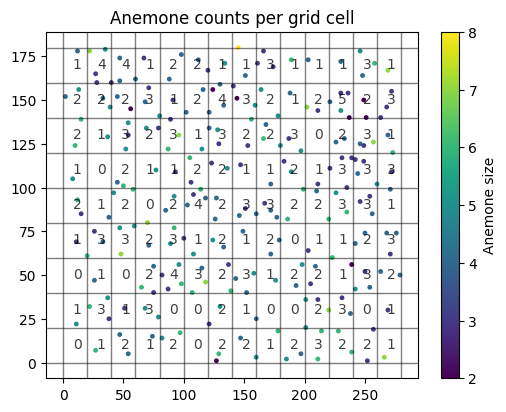

In [6]:
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(6, 4.5))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(data["x"], data["y"], c=data["marks"], s=6)

for i, row in enumerate(centroids):
    shifted_row = row - 2
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

plt.title("Anemone counts per grid cell"), plt.colorbar(label="Anemone size");

Podemos ver que todos los conteos son bastante bajos y varían de cero a cinco. Con todos nuestros datos preparados, podemos comenzar a escribir nuestro modelo probabilístico en PyMC. Vamos a tratar cada uno de los conteos por celda $Y_1,...Y_M$ como una variable aleatoria de Poisson.

Nuestro primer paso es asignar distribuciones previas a los parámetros de alto nivel para el proceso gaussiano. Esto incluye la escala de longitud $\rho$ para la función de covarianza y una media constante $\mu$ para el proceso gaussiano.

In [7]:
with pm.Model() as lgcp_model:
    mu = pm.Normal("mu", sigma=3)
    rho = pm.Uniform("rho", lower=25, upper=300)
    variance = pm.InverseGamma("variance", alpha=1, beta=1)
    cov_func = variance * pm.gp.cov.Matern52(2, ls=rho)
    mean_func = pm.gp.mean.Constant(mu)

A continuación, transformamos el proceso gaussiano en un proceso con valores positivos mediante `pm.math.exp` y usamos el área por celda para transformar la función de intensidad $\lambda(s)$ en tasas $\lambda_i$, que parametrizan la verosimilitud de Poisson para los conteos dentro de la celda $i$.

In [8]:
with lgcp_model:
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    log_intensity = gp.prior("log_intensity", X=centroids)
    intensity = pm.math.exp(log_intensity)

    rates = intensity * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

Con el modelo completamente especificado, podemos comenzar a muestrear desde el posterior utilizando el muestreador NUTS predeterminado. También ajustaré la tasa de aceptación objetivo para reducir el número de divergencias.

In [9]:
#se demora 1h
with lgcp_model:
    trace = pm.sample(1000, tune=2000, target_accept=0.95)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu, rho, variance, log_intensity_rotated_]


La inferencia posterior sobre el parámetro `length_scale` es útil para entender si existen o no correlaciones de largo alcance en los datos. También podemos examinar la media del campo de log-intensidad, pero dado que está en la escala logarítmica, es difícil interpretarla directamente.

In [ ]:
az.summary(trace, var_names=["mu", "rho"])

También estamos interesados en observar el valor del campo de intensidad en una gran cantidad de nuevos puntos en el espacio. Podemos ajustar esto en nuestro modelo incluyendo una nueva variable aleatoria para el proceso Gaussiano latente evaluado en un conjunto más denso de puntos. Usando `sample_posterior_predictive`, generamos predicciones posteriores sobre nuevos puntos de datos contenidos en la variable `intensity_new`.

In [ ]:
x_new = np.linspace(5, 275, 20)
y_new = np.linspace(5, 175, 20)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

with lgcp_model:
    intensity_new = gp.conditional("log_intensity_new", Xnew=xy_new)

    spp_trace = pm.sample_posterior_predictive(
        trace, var_names=["log_intensity_new"], keep_size=True
    )

trace.extend(spp_trace)
intensity_samples = np.exp(trace.posterior_predictive["log_intensity_new"])

Veamos algunas realizaciones de $\lambda(s)$. Dado que las muestras están en la escala logarítmica, necesitaremos exponenciarlas para obtener el campo de intensidad espacial de nuestro proceso de Poisson 2D. En el gráfico siguiente, se superpone el patrón de puntos observado.

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
axes = axes.ravel()

field_kwargs = {"marker": "o", "edgecolor": "None", "alpha": 0.5, "s": 80}

for i in range(6):
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], c=intensity_samples.sel(chain=0, draw=i), **field_kwargs
    )

    obs_handle = axes[i].scatter(data["x"], data["y"], s=10, color="k")
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")

plt.figlegend(
    (obs_handle, field_handle),
    ("Observed data", r"Posterior draws of $\lambda(s)$"),
    ncol=2,
    loc=(0.2, -0.01),
    fontsize=14,
    frameon=False,
);

Aunque hay algo de heterogeneidad en los patrones que muestran estas superficies, obtenemos una superficie media posterior con una definición espacial muy clara, con mayor intensidad en la parte superior derecha y menor intensidad en la parte inferior izquierda.

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)

plt.title("$E[\\lambda(s) \\vert Y]$")
plt.colorbar(label="Posterior mean");

La variación espacial en nuestras estimaciones del campo de intensidad puede no ser muy significativa si hay mucha incertidumbre. Podemos hacer un gráfico similar de la varianza posterior (o desviación estándar) en este caso:

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.var(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.title("$Var[\\lambda(s) \\vert Y]$"), plt.colorbar();

La varianza posterior es más baja en el centro del dominio y más alta en las esquinas y bordes. Esto tiene sentido: en ubicaciones donde hay más datos, tenemos estimaciones más precisas de los posibles valores del campo de intensidad.